In [3]:
import os
import cv2
import numpy as np

spectrograms = []
labels = []

In [4]:
import librosa

def extract_features(row):
    clips_path = "./dataset/data/clips/"
    clip_path = clips_path + row.path + ".mp3"
    features = {}
    
    # Loads the audio file as a floating point time series and assigns the default sample rate
    # Sample rate is set to 22050 by default
    X, sample_rate = librosa.load(clip_path) 

    # Generate Mel-frequency cepstral coefficients (MFCCs) from a time series 
    mfccs = np.mean(librosa.feature.mfcc(y=X, sr=sample_rate, n_mfcc=40).T,axis=0)
    features["mfccs"] = mfccs

    # Generates a Short-time Fourier transform (STFT) to use in the chroma_stft
    stft = np.abs(librosa.stft(X))
    features["stft"] = stft

    # Computes a chromagram from a waveform or power spectrogram.
    chroma = np.mean(librosa.feature.chroma_stft(S=stft, sr=sample_rate).T,axis=0)
    features["chroma"] = chroma

    # Computes a mel-scaled spectrogram.
    mel = np.mean(librosa.feature.melspectrogram(y=X, sr=sample_rate).T,axis=0)
    features["mel"] = mel

    # Computes spectral contrast
    contrast = np.mean(librosa.feature.spectral_contrast(S=stft, sr=sample_rate).T,axis=0)
    features["contrast"] = contrast

    # Computes the tonal centroid features (tonnetz)
    tonnetz = np.mean(librosa.feature.tonnetz(y=librosa.effects.harmonic(X),
    sr=sample_rate).T,axis=0)
    features["tonnetz"] = tonnetz        
    
    if(row.gender == "male"): row.gender = 1
    else: row.gender = 0


    print("mfccs:", mfccs)
    print("stft:", stft)
    print("chroma:", chroma)
    print("mel:", mel)
    print("contrast:", contrast)
    print("tonnetz:", tonnetz)
    
    # * columns: client_id, path, age, gender, mfccs, stft, chroma, mel, contract, tonnetz 
    data = [row.client_id, row.gender, mfccs, stft, chroma, mel, contrast, tonnetz]
    return data

In [5]:
def audio_pipeline(row):  
  clips_path = "./dataset/data/clips/"
  clip_path = clips_path + row.path + ".mp3"
  features = {}

  # Loads the audio file as a floating point time series and assigns the default sample rate
  # Sample rate is set to 22050 by default
  audio, sample_rate = librosa.load(clip_path) 

  if(row.gender == "male"): row.gender = 1
  else: row.gender = 0

  features = []

  features.append(row["client_id"])
  features.append(row["gender"])
  # Calcul du ZCR

  zcr = librosa.zero_crossings(audio)
  features.append(sum(zcr))

  # Calcul de la moyenne du Spectral centroid

  spectral_centroids = librosa.feature.spectral_centroid(y=audio)[0]
  features.append(np.mean(spectral_centroids))
  
  # Calcul du spectral rolloff point

  rolloff = librosa.feature.spectral_rolloff(y=audio)
  features.append(np.mean(rolloff))

  # Calcul des moyennes des MFCCs
  mfccs = librosa.feature.mfcc(y=audio)
  # print("mfccs len:", len(mfccs))

  for x in mfccs:
    features.append(np.mean(x))



  return features

# Read dataset


## rename client id

In [6]:
import pandas as pd 
import seaborn as sns
import matplotlib.pyplot as plt

dataframe = pd.read_table("./dataset/train.tsv")
dataframe = dataframe.drop(columns=["up_votes", "accent", "sentence", "down_votes"])

client_ids = dataframe.groupby(["client_id"]).sum().reset_index()["client_id"].tolist()
new_client_id = [x for x in range(len(client_ids) + 1)]

def rename_client(row):
    return client_ids.index(row["client_id"])

# * Rename client_id
dataframe["client_id"] = dataframe.apply(rename_client, axis=1)

print(dataframe["client_id"])

0        48
1        48
2        48
3        48
4        48
         ..
18933    58
18934    58
18935    58
18936    58
18937    58
Name: client_id, Length: 18938, dtype: int64


# Data filtering

<Axes: xlabel='client_id', ylabel='count'>

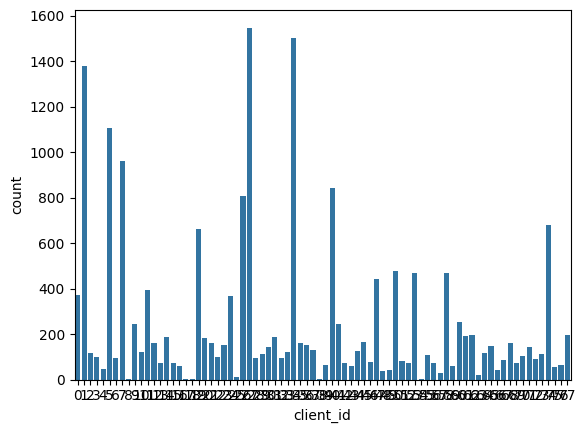

In [7]:
sns.countplot(x=dataframe["client_id"]) # plot the categories

In [2]:
filtered = pd.DataFrame(columns=dataframe.columns)
occurances = dataframe.groupby("client_id").size()

for occurance in occurances.items():
    # print("occurence", occurance)
    # ! filtre par occurances
    if(occurance[1] > 100):
        id = occurance[0]
        filtered = pd.concat([filtered, dataframe.query("client_id == @id")], ignore_index=True) 
 
print(len(filtered))
 

NameError: name 'pd' is not defined

In [94]:
filtered = pd.DataFrame(columns=dataframe.columns)
occurances = dataframe.groupby("client_id").size()

for occurance in occurances.items():
    # print("occurence", occurance)
    # ! filtre par occurances
    if(occurance[1] < 10):
        id = occurance[0]
        filtered = pd.concat([filtered, dataframe.query("client_id == @id")], ignore_index=True) 

print(filtered)

   client_id                                               path       age  \
0          8  f213174301329ae68441c30ed7fdeab777885ec32923e3...  fourties   
1          8  3aa0158ed7855a7c090d4f5e61e7e425a4d42f9b35bfc1...  fourties   
2          8  a1f4b25406e78c4cc01a5ae56e3dc46bd7f88b4cb7e560...  fourties   
3          8  b242305220c3b68c90f411ad574f7bb8a5d445190902a9...  fourties   
4         17  1daf5590b4e46dd71a41001d8545f4ffcde065a597d89a...  fourties   
5         17  eaff810238744f91723de542881655a6d4c4b99f3a5261...  fourties   
6         18  e2990a57f7f65098a259c9948e8efbaac8debed7889bed...  twenties   
7         18  45e16c0821c11273342c3836509a6d4b8de9ce7fd0310d...  twenties   
8         18  ad7ada58969ae813aeefc804ba8bf5ecc5cefbb84f0c86...  twenties   
9         18  4cb4b4c9268a53229c58621164710fa4c10911a75570e9...  twenties   
10        38  f407213280deb11f37d4c667fd34f31068652d3fc178b1...  fourties   
11        38  d1775fb5e4194562924b47e43ddb18929ec577e174463f...  fourties   

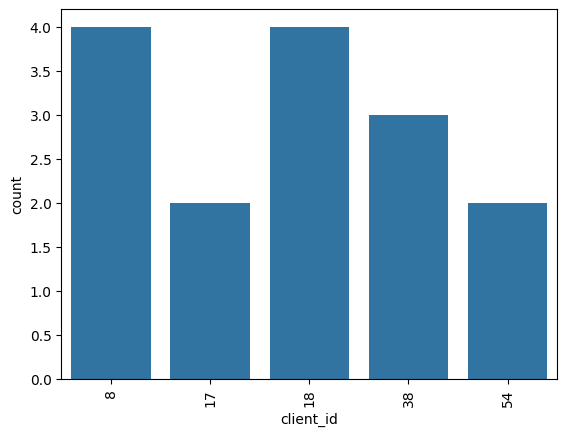

In [10]:
sns.countplot(x=filtered["client_id"]) # plot the categories
plt.xticks(rotation=90);

# Extract audio feature


## Custom code

In [ ]:

# * extrait des segment de 1 seconde de l'audio et les retourne
def extract_segments(audio, sr):
    # Définir la durée de chaque segment en secondes
    segment_duration = 1

    # Convertir la durée du segment en nombre d'échantillons
    segment_length = int(segment_duration * sr)

    # Découper l'audio en segments de 1 seconde
    segments = [audio[i : i + segment_length] for i in range(0, len(audio), segment_length)]
    return segments[-3:]

# * segmentes un audio et pour chaque segment extrait des features
def segment_audio_features(row):
    clips_path = "./dataset/data/clips/"
    audio_file = clips_path + row.path + ".mp3"
    audio, sr = librosa.load(audio_file)

    # Découper l'azaudio en segments de 1 seconde
    segments = extract_segments(audio, sr)
    # print("SEGMENTS:", row["client_id"], segments)
    
    # Extraction des caractéristiques pour chaque segment
    features = []
    for segment in segments:
        segment_features = extract_feature_from_segment(segment, row["client_id"])
        features.append(segment_features)

    return segments, features

# * extrait des features d'un segment d'audio
def extract_feature_from_segment(segment, client_id):
    features = []

    features.append(client_id)

    chroma_stft = librosa.feature.chroma_stft(y=segment)
    features.append(np.mean(chroma_stft))
    features.append(np.var(chroma_stft))

    rms = librosa.feature.rms(y=segment)
    features.append(np.mean(rms))
    features.append(np.var(rms))

    # Calcul de la moyenne du Spectral centroid

    # spectral_centroids = librosa.feature.spectral_centroid(y=segment)[0]
    spectral_centroids = librosa.feature.spectral_centroid(y=segment)
    features.append(np.mean(spectral_centroids))
    features.append(np.var(spectral_centroids))

    spectral_bandwidth = librosa.feature.spectral_bandwidth(y=segment)
    features.append(np.mean(spectral_bandwidth))
    features.append(np.var(spectral_bandwidth))

    rolloff = librosa.feature.spectral_rolloff(y=segment)
    features.append(np.mean(rolloff))
    features.append(np.var(rolloff))

    zcr = librosa.feature.zero_crossing_rate(y=segment)
    features.append(np.mean(zcr))
    features.append(np.var(zcr))

    harmony = librosa.effects.harmonic(y=segment)
    features.append(np.mean(harmony))
    features.append(np.var(harmony))

    tempo = librosa.feature.tempo(y=segment)
    features.append(tempo[0])

    # Calcul des moyennes des MFCC

    mfcc = librosa.feature.mfcc(y=segment)

    # print(len(mfcc))
    for x in mfcc:
        features.append(np.mean(x))
        features.append(np.var(x))
    # print("ftlen:", len(features))
    return features


In [1]:
columns_audio_pipeline = [
    "client",
    # "gender",
    # "mfcc1", "mfcc2", "mfcc3", "mfcc4", "mfcc5", "mfcc6", "mfcc7", "mfcc8", "mfcc9", "mfcc10", "mfcc11", "mfcc12", "mfcc13", "mfcc14", "mfcc15", "mfcc16", "mfcc17", "mfcc18", "mfcc19", "mfcc20",

    "mfcc1_mean",
    "mfcc1_var",
    "mfcc2_mean",
    "mfcc2_var",
    "mfcc3_mean",
    "mfcc3_var",
    "mfcc4_mean",
    "mfcc4_var",
    "mfcc5_mean",
    "mfcc5_var",
    "mfcc6_mean",
    "mfcc6_var",
    "mfcc7_mean",
    "mfcc7_var",
    "mfcc8_mean",
    "mfcc8_var",
    "mfcc9_mean",
    "mfcc9_var",
    "mfcc10_mean",
    "mfcc10_var",
    "mfcc11_mean",
    "mfcc11_var",
    "mfcc12_mean",
    "mfcc12_var",
    "mfcc13_mean",
    "mfcc13_var",
    "mfcc14_mean",
    "mfcc14_var",
    "mfcc15_mean",
    "mfcc15_var",
    "mfcc16_mean",
    "mfcc16_var",
    "mfcc17_mean",
    "mfcc17_var",
    "mfcc18_mean",
    "mfcc18_var",
    "mfcc19_mean",
    "mfcc19_var",
    "mfcc20_mean",
    "mfcc20_var",
    
    "chroma_stft_mean",
    "chroma_stft_var",
    
    "rms_mean", 
    "rms_var",

    "spectral_centroids_mean",
    "spectral_centroids_var",

    "spectral_bandwidth_mean",
    "spectral_bandwidth_var",
    
    "rolloff_mean", 
    "rolloff_var", 
    
    "zcr_mean", 
    "zcr_var", 

    "harmony_mean",
    "harmony_var",

    "tempo",
    # 'zcr', 'spectral_c', 'rolloff'
]
features_df = pd.DataFrame(columns=columns_audio_pipeline)

index = 0
client_index = 0
for i in range(len(filtered)):
    row = filtered.loc[i]
    print("Client id:", row.client_id)
    # * Build audio clip path
    clips_path = "./dataset/data/clips/"
    audio_file = clips_path + row.path + ".mp3"
    
    # * Load audio
    audio, sr = librosa.load(audio_file)
    
    # * read feature from audio pist
    features = extract_feature_from_segment(audio, row["client_id"])
    
    # * append audio feature to the feature dataframe
    features_df.loc[index] = feature
    index += 1
    client_index += 1

print(features_df)

NameError: name 'pd' is not defined

In [ ]:
features_df.to_csv("./dataset/train/extracted_features_100.csv", index = False)

In [100]:
## Split audio to segmented part
# columns = ["client", "gender", "mfccs", "stft", "chroma", "mel", "contrast", "tonnetz"]
columns_audio_pipeline = [
    "client",
    # "gender",
    # "mfcc1", "mfcc2", "mfcc3", "mfcc4", "mfcc5", "mfcc6", "mfcc7", "mfcc8", "mfcc9", "mfcc10", "mfcc11", "mfcc12", "mfcc13", "mfcc14", "mfcc15", "mfcc16", "mfcc17", "mfcc18", "mfcc19", "mfcc20",

    "mfcc1_mean",
    "mfcc1_var",
    "mfcc2_mean",
    "mfcc2_var",
    "mfcc3_mean",
    "mfcc3_var",
    "mfcc4_mean",
    "mfcc4_var",
    "mfcc5_mean",
    "mfcc5_var",
    "mfcc6_mean",
    "mfcc6_var",
    "mfcc7_mean",
    "mfcc7_var",
    "mfcc8_mean",
    "mfcc8_var",
    "mfcc9_mean",
    "mfcc9_var",
    "mfcc10_mean",
    "mfcc10_var",
    "mfcc11_mean",
    "mfcc11_var",
    "mfcc12_mean",
    "mfcc12_var",
    "mfcc13_mean",
    "mfcc13_var",
    "mfcc14_mean",
    "mfcc14_var",
    "mfcc15_mean",
    "mfcc15_var",
    "mfcc16_mean",
    "mfcc16_var",
    "mfcc17_mean",
    "mfcc17_var",
    "mfcc18_mean",
    "mfcc18_var",
    "mfcc19_mean",
    "mfcc19_var",
    "mfcc20_mean",
    "mfcc20_var",
    
    "chroma_stft_mean",
    "chroma_stft_var",
    
    "rms_mean", 
    "rms_var",

    "spectral_centroids_mean",
    "spectral_centroids_var",

    "spectral_bandwidth_mean",
    "spectral_bandwidth_var",
    
    "rolloff_mean", 
    "rolloff_var", 
    
    "zcr_mean", 
    "zcr_var", 

    "harmony_mean",
    "harmony_var",

    "tempo",
    # 'zcr', 'spectral_c', 'rolloff'
]
features_df = pd.DataFrame(columns=columns_audio_pipeline)

# print(len(filtered))
# print(filtered)
index = 0
for i in range(len(filtered)):
    row = filtered.loc[i]
    print(row["client_id"])
    # ! Segmented audio
    segments, features = segment_audio_features(filtered.loc[i])
    print("nb segment", len(segments))
    for feature in features:
        
        features_df.loc[index] = feature
        index += 1
features_df

features_df.to_csv("./dataset/data/fitlered_segemented._featurescsv", index=False)

0
nb segment 3
0


/home/lucas/PersonalDEV/voice-recognizer/.venv/lib/python3.11/site-packages/librosa/core/spectrum.py:257: UserWarning: n_fft=2048 is too large for input signal of length=530
  warnings.warn(


nb segment 3
0
nb segment 3
0
nb segment 3
0
nb segment 3
0
nb segment 3
0
nb segment 3
0


/home/lucas/PersonalDEV/voice-recognizer/.venv/lib/python3.11/site-packages/librosa/core/spectrum.py:257: UserWarning: n_fft=2048 is too large for input signal of length=1588
  warnings.warn(


nb segment 3
0
nb segment 3
0
nb segment 3
0
nb segment 3
0
nb segment 3
0
nb segment 3
0


/home/lucas/PersonalDEV/voice-recognizer/.venv/lib/python3.11/site-packages/librosa/core/spectrum.py:257: UserWarning: n_fft=2048 is too large for input signal of length=530
  warnings.warn(
/home/lucas/PersonalDEV/voice-recognizer/.venv/lib/python3.11/site-packages/librosa/core/pitch.py:101: UserWarning: Trying to estimate tuning from empty frequency set.
  return pitch_tuning(


nb segment 3
0
nb segment 3
0
nb segment 3
0
nb segment 3
0
nb segment 3
0
nb segment 3
0
nb segment 3
0
nb segment 3
0
nb segment 3
0
nb segment 3
0
nb segment 3
0
nb segment 3
0
nb segment 3
0
nb segment 3
0
nb segment 3
0
nb segment 3
0
nb segment 3
0
nb segment 3
0
nb segment 3
0
nb segment 3
0
nb segment 3
0
nb segment 3
0
nb segment 3
0
nb segment 2
0
nb segment 3
0
nb segment 3
0
nb segment 3
0
nb segment 3
0
nb segment 3
0
nb segment 3
0
nb segment 3
0
nb segment 3
0
nb segment 3
0
nb segment 2
0
nb segment 3
0


KeyboardInterrupt: 

In [71]:
print("features of segments:")
features_df

features of segments:


,client,mfcc1_mean,mfcc1_var,mfcc2_mean,mfcc2_var,mfcc3_mean,mfcc3_var,mfcc4_mean,mfcc4_var,mfcc5_mean,...,spectral_centroids_var,spectral_bandwidth_mean,spectral_bandwidth_var,rolloff_mean,rolloff_var,zcr_mean,zcr_var,harmony_mean,harmony_var,tempo
0,8.0,0.463403,0.090818,0.055305,4.248711e-03,2037.811794,8.644955e+05,2335.946870,470068.011588,4500.928844,...,4.001579,53.376125,-2.232567,45.145313,0.816798,44.920036,1.288119,20.982925,-2.434720,46.480011
1,8.0,0.358354,0.093283,0.072558,2.190277e-03,1102.594326,2.259921e+05,1457.854527,261641.282580,1999.896240,...,3.650757,43.831234,3.200556,56.180912,-2.006909,49.207497,-3.929058,27.174402,1.048661,41.438660
2,8.0,0.489529,0.083692,0.000805,3.122790e-08,2076.854606,9.386636e+04,2689.613134,62147.551475,5097.007058,...,6.646700,20.919336,4.281754,22.554476,4.344616,30.334978,-2.642743,24.830452,6.446429,15.907321
3,8.0,0.392197,0.092067,0.119168,5.536747e-03,1530.408850,9.010258e+05,1717.012084,366867.719641,2934.143621,...,-1.538054,117.877975,5.712725,67.836365,0.045525,55.390163,-0.346727,102.184090,1.718883,51.157764
4,8.0,0.428786,0.088292,0.028186,1.638203e-03,1769.477804,2.965643e+05,2146.673650,418239.587757,3750.203081,...,5.876849,50.673771,-5.146387,110.301628,1.494101,54.660229,3.503537,22.982924,0.314368,30.418770
5,8.0,0.634828,0.041112,0.000229,0.000000e+00,2039.528919,1.410434e+03,2449.970382,160.598548,4425.073242,...,-2.169284,0.007914,-1.390587,0.180717,8.332781,9.432324,6.910899,4.405143,1.812554,1.264377
6,8.0,0.366507,0.085576,0.068878,9.442279e-04,1413.651125,4.190068e+05,1527.531558,160983.073319,2481.946356,...,-0.382535,78.019539,-3.914725,34.305775,-4.991414,50.863182,-1.708132,57.299526,-3.340326,36.308434
7,8.0,0.370091,0.094272,0.043206,1.362284e-03,1816.061120,6.866565e+05,2102.472196,256889.798082,3639.845415,...,-0.432616,64.037605,4.422057,47.270657,-1.004369,81.712067,-0.422657,50.119373,0.399295,46.647327
8,8.0,0.487433,0.087473,0.000279,1.249753e-09,2090.622763,1.402915e+04,2713.998143,7015.371584,5252.666016,...,5.023406,31.816219,3.392893,14.435769,3.967775,7.345579,-1.821997,14.602457,2.423588,13.651359
9,8.0,0.303048,0.099795,0.086298,9.320506e-04,1745.081576,2.299218e+06,1844.443663,678671.503850,3306.570157,...,0.702861,79.468834,-3.943883,39.545467,-0.471851,49.421482,-8.724715,60.310070,-1.125065,50.323399


In [13]:
labels = features_df['client']
features = features_df.drop('client', axis = 1)
print("feature to frame:", labels.to_frame())
labels.shape

feature to frame:     client
0      8.0
1      8.0
2      8.0
3      8.0
4      8.0
5      8.0
6      8.0
7      8.0
8      8.0
9      8.0
10     8.0
11     8.0
12    17.0
13    17.0
14    17.0
15    17.0
16    17.0
17    17.0
18    18.0
19    18.0
20    18.0
21    18.0
22    18.0
23    18.0
24    18.0
25    18.0
26    18.0
27    18.0
28    18.0
29    18.0
30    38.0
31    38.0
32    38.0
33    38.0
34    38.0
35    38.0
36    38.0
37    38.0
38    38.0
39    54.0
40    54.0
41    54.0
42    54.0
43    54.0
44    54.0


(45,)

In [14]:
# split data to train and test data
from sklearn.model_selection import train_test_split

labels_ = [x for x in set(labels)]
print("labels", labels_)
x = np.array(features, dtype = float)
y = np.array(labels)

print(y)
x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.33)
x_train.shape, x_test.shape, y_train.shape, y_test.shape


labels [38.0, 8.0, 17.0, 18.0, 54.0]
[ 8.  8.  8.  8.  8.  8.  8.  8.  8.  8.  8.  8. 17. 17. 17. 17. 17. 17.
 18. 18. 18. 18. 18. 18. 18. 18. 18. 18. 18. 18. 38. 38. 38. 38. 38. 38.
 38. 38. 38. 54. 54. 54. 54. 54. 54.]


((30, 55), (15, 55), (30,), (15,))

In [15]:
from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import StandardScaler

encoder = LabelEncoder()
scaler = StandardScaler()

x_train = scaler.fit_transform(x_train)
y_train = encoder.fit_transform(y_train)

x_test = scaler.fit_transform(x_test)
y_test = encoder.fit_transform(y_test)

# print(x_train[0])
x.shape, y.shape

((45, 55), (45,))

# Model function


In [16]:
from keras.models import Sequential
from keras.layers import Dense

def create_model():
    # création du modèle
    model = Sequential()
    model.add(Dense(25, input_shape=(55,), activation='relu'))
    model.add(Dense(10, activation='softmax'))

    model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
    model.summary()
    return model

2024-03-15 19:25:20.784854: I tensorflow/core/util/port.cc:113] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2024-03-15 19:25:20.859401: I external/local_tsl/tsl/cuda/cudart_stub.cc:31] Could not find cuda drivers on your machine, GPU will not be used.
2024-03-15 19:25:21.187918: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-03-15 19:25:21.187975: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-03-15 19:25:21.260755: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to

In [17]:
print(len(new_client_id))

79


In [18]:
from tensorflow import keras
from keras.optimizers import Adam
import tensorflow as tf



# build model
model = keras.models.Sequential([
    keras.layers.Dense(64, activation = 'relu', input_shape = (x_train.shape[1],)),
    keras.layers.Dropout(0.2),
    keras.layers.Dense(32, activation='relu'),
    keras.layers.Dense(27, activation = 'softmax'),
    
])
# model.set_weights()
model.summary()


Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense (Dense)               (None, 64)                3584      
                                                                 
 dropout (Dropout)           (None, 64)                0         
                                                                 
 dense_1 (Dense)             (None, 32)                2080      
                                                                 
 dense_2 (Dense)             (None, 27)                891       
                                                                 
Total params: 6555 (25.61 KB)
Trainable params: 6555 (25.61 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


2024-03-15 19:25:23.344779: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:901] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
2024-03-15 19:25:23.345206: W tensorflow/core/common_runtime/gpu/gpu_device.cc:2256] Cannot dlopen some GPU libraries. Please make sure the missing libraries mentioned above are installed properly if you would like to use GPU. Follow the guide at https://www.tensorflow.org/install/gpu for how to download and setup the required libraries for your platform.
Skipping registering GPU devices...


In [19]:
y_test.shape = (y_test.shape[0], 1)
y_train.shape = (y_train.shape[0], 1)

print(y_train.shape)
print(y_test.shape)

print(x_train.shape, x_test.shape)
y_train

(30, 1)
(15, 1)
(30, 55) (15, 55)


array([[4],
       [0],
       [1],
       [0],
       [1],
       [2],
       [0],
       [3],
       [0],
       [3],
       [4],
       [0],
       [3],
       [4],
       [4],
       [2],
       [3],
       [3],
       [4],
       [1],
       [2],
       [3],
       [0],
       [0],
       [1],
       [3],
       [2],
       [2],
       [2],
       [0]])

In [69]:

# compile model  
# model.compile(optimizer=keras.optimizers.Adam(learning_rate=0.001),loss='categorical_crossentropy',metrics='accuracy')
# tf.random.set_seed(1)
model.compile(
    optimizer=keras.optimizers.Adam(learning_rate=0.005),
    loss='sparse_categorical_crossentropy',
    metrics='accuracy'
)
# entrainement du  modèles
history = model.fit(x_train, y_train, epochs=5, batch_size=128, validation_data=(x_test, y_test))
test_loss, test_accuracy = model.evaluate(x_test, y_test)

print("Test Loss:", test_loss)
print("Test Accuracy:", test_accuracy)

Epoch 1/5
1/1 [==============================] - 0s 498ms/step - loss: 0.0000e+00 - accuracy: 1.0000 - val_loss: 60.1242 - val_accuracy: 0.8000
Epoch 2/5
1/1 [==============================] - 0s 29ms/step - loss: 0.0000e+00 - accuracy: 1.0000 - val_loss: 60.1242 - val_accuracy: 0.8000
Epoch 3/5
1/1 [==============================] - 0s 25ms/step - loss: 0.0000e+00 - accuracy: 1.0000 - val_loss: 60.1242 - val_accuracy: 0.8000
Epoch 4/5
1/1 [==============================] - 0s 29ms/step - loss: 0.0000e+00 - accuracy: 1.0000 - val_loss: 60.1242 - val_accuracy: 0.8000
Epoch 5/5
1/1 [==============================] - 0s 21ms/step - loss: 60.1242 - accuracy: 0.8000
Test Loss: 60.12419509887695
Test Accuracy: 0.800000011920929


In [21]:
# Evaluate the model
test_loss, test_accuracy = model.evaluate(x_test, y_test)

print("Test Loss:", test_loss)
print("Test Accuracy:", test_accuracy)

1/1 [==============================] - 0s 16ms/step - loss: 11.4904 - accuracy: 0.6000
Test Loss: 11.490446090698242
Test Accuracy: 0.6000000238418579


In [1]:
loss_curve = history.history["loss"]
acc_curve = history.history["accuracy"]

loss_val_curve = history.history["val_loss"]
acc_val_curve = history.history["val_accuracy"]

plt.plot(loss_curve, label="Train")
plt.plot(loss_val_curve, label="Val")
plt.legend(loc='upper left  ')
plt.title("Loss")
plt.show()

plt.plot(acc_curve, label="Train")
plt.plot(acc_val_curve, label="Val")
plt.legend(loc='upper left')
plt.title("Accuracy")
plt.show()

NameError: name 'history' is not defined

In [23]:
labels = np.array(labels[:])
print("labels:", labels, len(labels))

print("features:")
print(x_test)

labels: [ 8.  8.  8.  8.  8.  8.  8.  8.  8.  8.  8.  8. 17. 17. 17. 17. 17. 17.
 18. 18. 18. 18. 18. 18. 18. 18. 18. 18. 18. 18. 38. 38. 38. 38. 38. 38.
 38. 38. 38. 54. 54. 54. 54. 54. 54.] 45
features:
[[-1.36560410e-01  1.24482302e-01 -8.64647816e-01 -8.57358467e-01
   1.52063222e+00  5.25549024e-01  1.14746548e+00 -5.37278208e-02
   1.26528953e+00 -7.83266077e-03  1.54751304e+00 -1.39723105e-01
   3.15995814e-01 -6.02071884e-01  1.54694681e+00 -7.18910500e-01
  -9.32791071e-01 -1.16391443e+00 -1.04460015e+00 -1.11802500e+00
  -5.24831207e-01 -4.63930627e-01 -4.94862979e-01  5.92238290e-01
  -8.08079091e-01  5.35506936e-01 -7.56408672e-01  1.20790413e+00
  -8.23874227e-01  2.91998406e-01 -7.96330360e-01  7.57977742e-01
  -5.85660085e-01 -8.01038116e-01 -7.69906743e-01  1.46121022e+00
  -9.07394791e-01  4.53064609e-02 -4.46019105e-01  4.66723157e-01
  -6.78227463e-01 -1.46540317e-02  5.22253614e-01 -2.54920159e-01
  -1.18157549e+00 -7.66500067e-01 -9.46729828e-01 -9.25184238e-01
  -

In [24]:

print(len(new_client_id))
print(len(x_train))
print(len(x_test))

79
30
15


In [25]:
from sklearn.metrics import confusion_matrix 

sns.set()
predictions = model.predict(x_test)

genres = [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26]
probs = np.exp(predictions) / np.sum(np.exp(predictions), axis=1, keepdims=True)

predicted_classes = np.argmax(probs, axis=1)
predicted_class_names = [genres[class_index] for class_index in predicted_classes]


for i in range(len(predicted_class_names)):
    print(f"Prédiction pour la musique {i + 1}: {predicted_class_names[i]}")



1/1 [==============================] - 0s 57ms/step
Prédiction pour la musique 1: 0
Prédiction pour la musique 2: 1
Prédiction pour la musique 3: 3
Prédiction pour la musique 4: 4
Prédiction pour la musique 5: 4
Prédiction pour la musique 6: 3
Prédiction pour la musique 7: 4
Prédiction pour la musique 8: 0
Prédiction pour la musique 9: 2
Prédiction pour la musique 10: 3
Prédiction pour la musique 11: 0
Prédiction pour la musique 12: 4
Prédiction pour la musique 13: 0
Prédiction pour la musique 14: 3
Prédiction pour la musique 15: 0


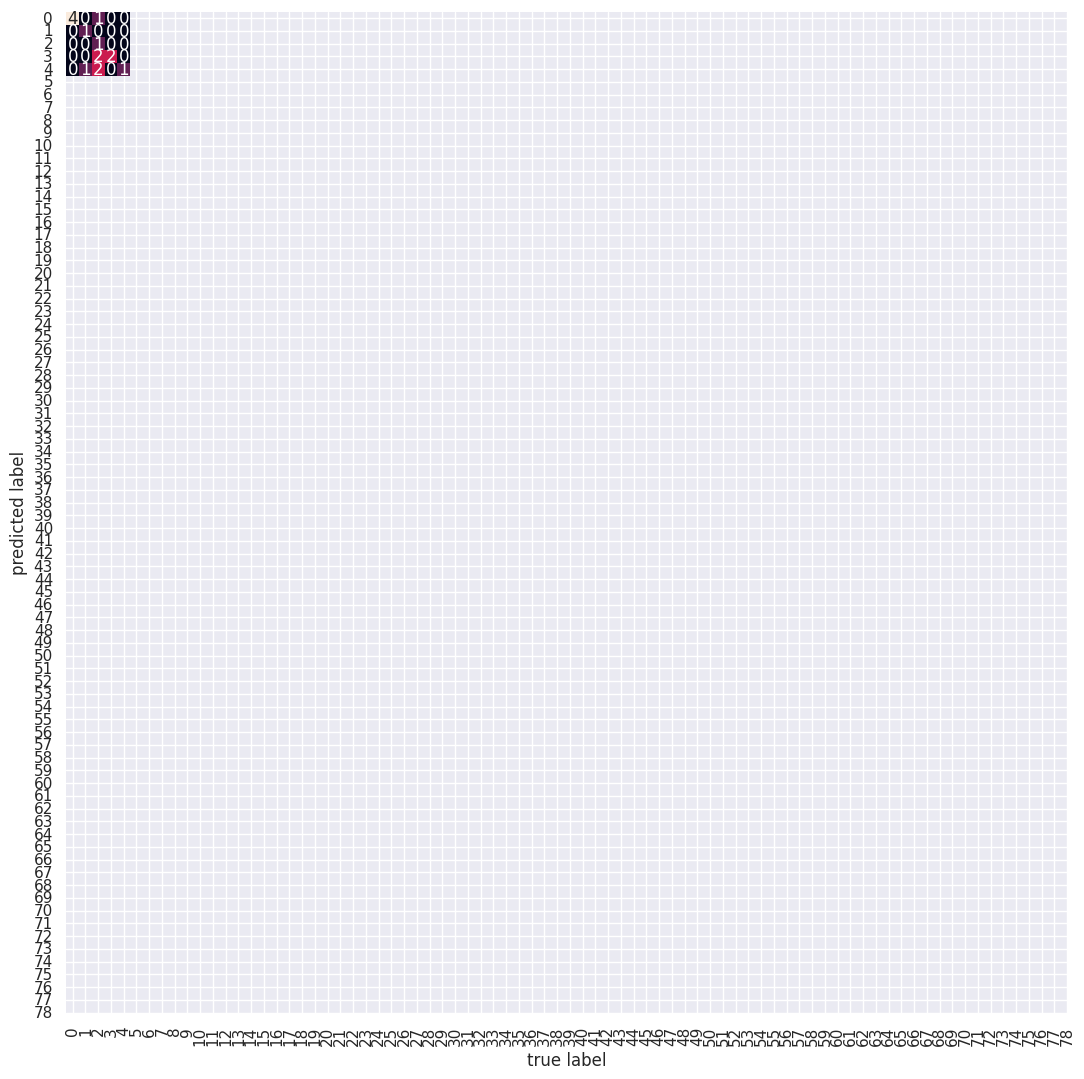

In [26]:
mat = confusion_matrix(y_test, np.argmax(predictions, 1))
plt.figure(figsize=(15, 13))
sns.heatmap(mat.T, square=True, annot=True, fmt='d', cbar=False, xticklabels=new_client_id, yticklabels=new_client_id)
plt.xlabel('true label')
plt.ylabel('predicted label')
plt.show()

In [27]:
print(predictions[1], len(predictions[1]))
print(len(y_test))

[2.83147041e-13 9.10776615e-01 4.42182128e-23 8.92233923e-02
 1.04297999e-16 0.00000000e+00 2.39160098e-36 1.14348656e-37
 2.56072031e-35 4.71583380e-36 0.00000000e+00 1.43785459e-34
 0.00000000e+00 3.88772275e-33 9.57850036e-36 1.38465965e-36
 8.30182526e-33 3.17169419e-36 4.01552034e-36 1.30384746e-36
 0.00000000e+00 1.59251790e-36 0.00000000e+00 4.86963189e-37
 3.76048311e-34 0.00000000e+00 0.00000000e+00] 27
15
